In [6]:
!ls

 CA_county_pops2019.csv		   __pycache__
 election_images		  'Texas Counties by Population_files'
 election_plots.ipynb		  'Texas Counties by Population.html'
 election.py			   texas_files
 election_results_thoughts.ipynb   texas.html
 how_swingable_is_texas.ipynb	   virginia.json


# How Swing-able is Texas?
- could texas swing be more than just a dance move
- what does 600k vote difference mean? could that be made up easily by dems?
- we watched Georgia swing this year (personally blew my mind), begs the question which other ones could swing?
- went to undergrad at Trinity University and even though the cities vote blue, the state still feels very red (I think you can probably imagine what I mean by this)
- this is where I make my point about an election being a biased sample of the population (i.e. its a look at what the people think but because it is only a subset and that subset may not be evenly sampled... it lends itself to bias)
- there in lies an opportunity 
- did a similar analysis by breaking it down to county level as with Virginia
- we have plenty of data to assume those p numbers are set (again, unless the counties themselves are biased but lets ignore that for now)
- its pretty red still
- but we saw record turnouts and with back of the envelope calc, shows that Republican counties actually had a higher turnout (by population).  It could be argued that the more rigorous way of calculating this would be by voter registration but who is to say that isn't a biased sample too. There are tradeoffs to both because bigger cities might have more uneligible voters which would inflate some of the Biden projections but lets just go with this because my main point isn't exactly hinging on this assumption (although I want to be transparent about it). you could also make the point that dems don't register because they don't think TX will ever go blue (I have several friends in Texas who have said just that)... its hard to say (because they aren't registered), so I just chose population (put this at bottom)
- main point is that if only 51% of voting age people voted, 52% rep, 50 dem, then those 600k votes could easily be made up in a scenario where dems were ultra inspired to vote (and thus went trhough the trouble of registering and showing up).  its just a 6% increase in their turnout and thats assuming the republicans don't change. A situation could exist where they drop by 3% (which would only be slightly below the dem's turnout) and then 


In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

https://www.texas-demographics.com/counties_by_population

In [8]:
with open('Texas Counties by Population.html') as popfile:
    html = popfile.read()

psoup = BeautifulSoup(html, 'html.parser')
table = psoup.find(lambda tag: tag.name=='table') 
rows = table.findAll(lambda tag: tag.name=='tr')
rows[3]

<tr>
<td>
        3
      </td>
<td>
<a href="https://www.texas-demographics.com/tarrant-county-demographics">Tarrant County</a>
</td>
<td>
        2,102,515

      </td>
</tr>

In [9]:
pops = []
for row in rows[1:255]:
    elems = row.findAll(lambda tag: tag.name == 'td')
    county = []
    for elem in elems:
        county.append(elem.text.strip())
    pops.append(county)
pops = pd.DataFrame(pops,columns = ['rank','county','pop'])
# gets confused by commas
pops['pop'] = pops['pop'].str.replace(',','').astype(int)
# assume 75% of population were voting age (as 2016 data suggests https://www.pewresearch.org/fact-tank/2020/11/03/in-past-elections-u-s-trailed-most-developed-countries-in-voter-turnout/)
pops['voters'] = (pops['pop']*0.75).astype(int)
pops.head()

,rank,county,pop,voters
0,1,Harris County,4713325,3534993
1,2,Dallas County,2635516,1976637
2,3,Tarrant County,2102515,1576886
3,4,Bexar County,2003554,1502665
4,5,Travis County,1273954,955465


https://www.politico.com/2020-election/results/texas/

In [10]:
with open('texas.html') as votingfile:
    html = votingfile.read()

vsoup = BeautifulSoup(html, 'html.parser')
# there are 4 tables and first three are garbage
tables = vsoup.findAll(lambda tag: tag.name=='table')
table = tables[3]
# find all the rows
rows = table.findAll(lambda tag: tag.name=='tr')
len(rows)

255

In [11]:
votes = []
for row in rows[1:]:
    elems = row.findAll(lambda tag: tag.name == 'td')
    county = []
    for elem in elems:
        county.append(elem.text.strip())
    votes.append(county)
votes = pd.DataFrame(votes,columns = ['county','nTrump','perTrump','nBiden','perBiden'])
# change vote columns to ints
for col in ['nTrump','nBiden']: votes[col] = votes[col].str.replace(',','').astype(int)
# change percent column to floats
for col in ['perTrump','perBiden']: votes[col] = votes[col].str.replace('%','').astype(float)/100
votes['total'] = votes.nBiden + votes.nTrump
votes.head()

,county,nTrump,perTrump,nBiden,perBiden,total
0,Anderson County,15062,0.787,3934,0.205,18996
1,Andrews County,4937,0.843,849,0.145,5786
2,Angelina County,25070,0.726,9136,0.264,34206
3,Aransas County,9210,0.752,2896,0.237,12106
4,Archer County,4300,0.897,446,0.093,4746


Add the population

In [12]:
texas = pd.merge(votes,pops[['county','voters','pop']],how='left',right_on = 'county',left_on='county')
texas['votes'] = texas.nBiden + texas.nTrump
texas.head()

,county,nTrump,perTrump,nBiden,perBiden,total,voters,pop,votes
0,Anderson County,15062,0.787,3934,0.205,18996,43301,57735,18996
1,Andrews County,4937,0.843,849,0.145,5786,14028,18705,5786
2,Angelina County,25070,0.726,9136,0.264,34206,65036,86715,34206
3,Aransas County,9210,0.752,2896,0.237,12106,17632,23510,12106
4,Archer County,4300,0.897,446,0.093,4746,6414,8553,4746


Half of the votes came from the top 5 counties

Text(0.5, 0, '')

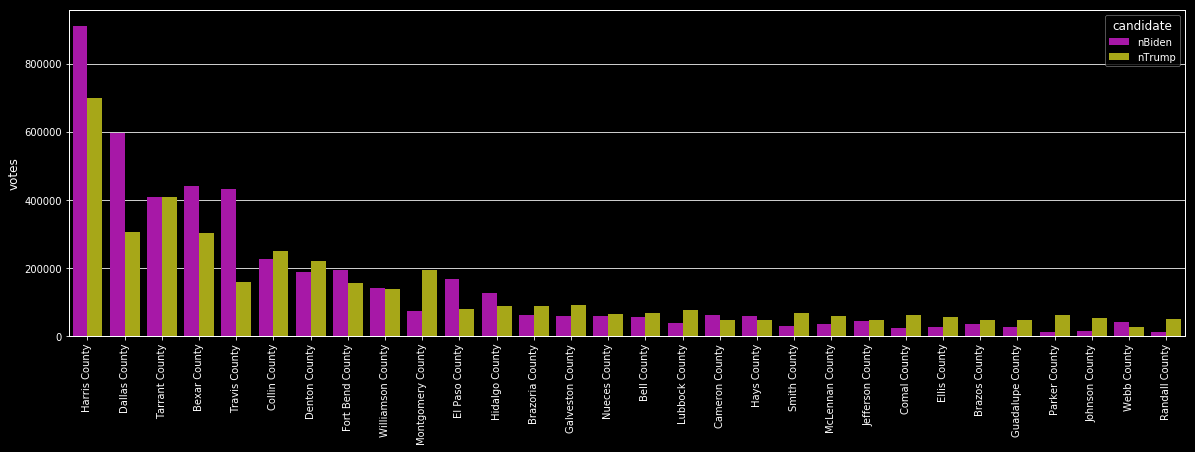

In [27]:
df = texas.sort_values('total',ascending=False).iloc[:30]

x = 'county'
y = 'votes'
hue = 'candidate'

melted_df = pd.melt(df[['nBiden','nTrump', x]], id_vars=[x],var_name=hue, value_name = y)

plt.figure(figsize=(20,6))
sns.barplot(x=x, y=y, hue=hue, data=melted_df, palette=['m','y'])
plt.xticks(rotation=90); plt.xlabel('')

In [29]:
texas.query('county == "Harris County"')

,county,nTrump,perTrump,nBiden,perBiden,total,voters,pop,votes,nBiden_pot,nTrump_pot
100,Harris County,699822,0.428,911974,0.558,1611796,3534993,4713325,1611796,1972526,1512977


In [13]:
texas['nBiden_pot'] = (texas.voters * texas.perBiden).astype(int)
texas['nTrump_pot'] = (texas.voters * texas.perTrump).astype(int)
texas.head()

,county,nTrump,perTrump,nBiden,perBiden,total,voters,pop,votes,nBiden_pot,nTrump_pot
0,Anderson County,15062,0.787,3934,0.205,18996,43301,57735,18996,8876,34077
1,Andrews County,4937,0.843,849,0.145,5786,14028,18705,5786,2034,11825
2,Angelina County,25070,0.726,9136,0.264,34206,65036,86715,34206,17169,47216
3,Aransas County,9210,0.752,2896,0.237,12106,17632,23510,12106,4178,13259
4,Archer County,4300,0.897,446,0.093,4746,6414,8553,4746,596,5753


In [14]:
sums = texas.sum()
sums

county        Anderson CountyAndrews CountyAngelina CountyAr...
nTrump                                                  5865248
perTrump                                                188.964
nBiden                                                  5217656
perBiden                                                 62.338
total                                                  11082904
voters                                                 21746816
pop                                                    28995881
votes                                                  11082904
nBiden_pot                                             10294773
nTrump_pot                                             11146375
dtype: object

More Republicans vote in Texas as shown by Trump's percentage going down. This might be because

potential trump percentage (note it was 46.4 52.2)

In [15]:
sums.nTrump_pot/sums.voters

0.5125520444004309

Potential biden

In [16]:
sums.nBiden_pot/sums.voters

0.47339219681630634

Total percentage who voted (50%, much lower than some of the numbers they are projecting for the national average). of course, we are assuming 75% of the total population... which is already a rough number and doesnt include non-eligible persons of voting age (e.g. immigrants)

In [17]:
sums.votes/sums.voters

0.5096334102426765

Republican percentage who voted

In [18]:
sums.nTrump/ sums.nTrump_pot

0.5262022854964058

Democrat percentage who voted

In [19]:
sums.nBiden/ sums.nBiden_pot

0.5068257454535423

How many more percentage of democrat voters needed to turn up. Still under the national average (you see projections saying 66% of people voted... of course, they may be comparing it to registered voters... actually just saw the same numbers for Texas too).  Shows that not everyone is registered (again, maybe more dems would register if they knew they could swing the state)

In [20]:
diff = sums.nTrump - sums.nBiden 
diff, diff/ sums.nBiden_pot*100

(647592, 6.290493243512994)

how much more of state would need to show up at polls (6% seems like alot of dems but its actually not that many texans

In [21]:
diff/sums.voters *100

2.9778704156047486

https://www.texastribune.org/2020/11/04/texas-voter-turnout-democrats/

